# Forecasting 🔮 

## Load the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.DataFrame(
    {"Month": [1,2,3,4,5,6,7,8,9,10,11,12],
    "Sales": [5384, 8081, 10282, 9156, 6118, 9139, 12460, 10717, 7825, 9693, 15177, 10990]}
)

df

,Month,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118
5,6,9139
6,7,12460
7,8,10717
8,9,7825
9,10,9693


## Visualize and interpret the pattern of this time-series

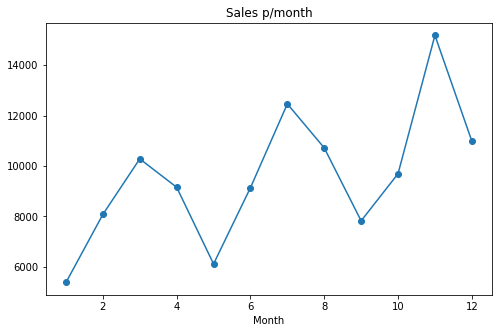

In [2]:
plt.figure(figsize=(8,5))

plt.title("Sales p/month")
plt.xlabel("Month")
plt.plot(df["Month"], df["Sales"], marker='o');

* ###  The above data appears to have a seasonal pattern. Every four months the sales will begin in a trough, cycle through a peak then return to a trough.

* ###  Aside from the seasonal pattern, the sales are in general showing an upward trend. Each peak and trough is higher than the of the previous 4 month season. Business owners should be pleased to see this growth.

## Predicting future demand in months 13,14,15, without seasonality

### 1. Using Moving Average

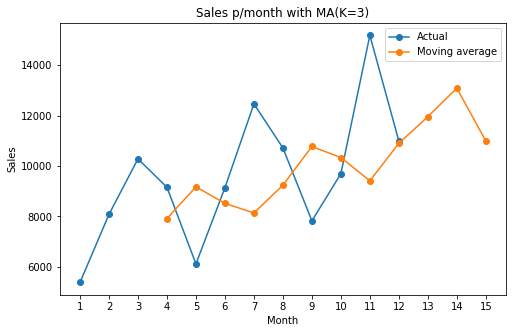

In [3]:
df_predict = df.copy()

# Calculate rolling. Use offset to match lecture slides version of lagged rolling.
offset = pd.Series([None])
rolling = offset.append(df_predict.rolling(window=3).mean()['Sales'])
rolling.reset_index(drop=True, inplace=True)

# Create new df col
df_predict['MA'] = rolling

# Predict results for months 13,14,15
for month in range(13, 16):
    ma_pred = df_predict.iloc[-3:]["Sales"].mean()
    df_predict = df_predict.append({'Month': month, 'Sales': None, 'MA': ma_pred}, ignore_index=True)

plt.figure(figsize=(8,5))
plt.title("Sales p/month with MA(K=3)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(range(1, 16))
plt.plot(df_predict["Month"], df_predict["Sales"], marker='o', label="Actual");
plt.plot(df_predict["Month"], df_predict["MA"], marker='o', label="Moving average");
plt.legend()

### 2. Exponential Smoothing

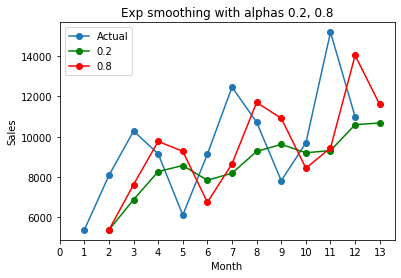

In [4]:
# Create exp smoothing predictions
exp_smooth1 = df["Sales"].ewm(alpha=0.2).mean()
exp_smooth2 = df["Sales"].ewm(alpha=0.8).mean()

# Offset
offset = pd.Series([None])
exp_smooth1 = offset.append(exp_smooth1)
exp_smooth2 = offset.append(exp_smooth2)

plt.plot(df["Month"], df["Sales"], marker='o', label="Actual");
plt.plot(range(1, 14), exp_smooth1, marker='o', label="0.2", color="green");
plt.plot(range(1, 14), exp_smooth2, marker='o', label="0.8", color="red");
plt.title("Exp smoothing with alphas 0.2, 0.8")
plt.ylabel("Sales")
plt.xlabel("Month")

plt.xticks(range(14))
plt.legend()

## 3. Predict future demand in month 13,14,15,16 with seasonality

In [7]:
# Generate polynomial regression

season = np.array([1,2,3])
avg_arr = np.array([df["Sales"][:4].mean(), df["Sales"][4:8].mean(), df["Sales"][8:].mean()])
fit = np.polyfit(season, avg_arr, 3)
poly = np.poly1d(fit)
season_4_prediction = poly(4)

print("Season average prediction: ", season_4_prediction)

Season average prediction:  12038.807805355968


/Users/gu/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
seasonal_averages = []
# For the 3 mini summers [0, 4, 8], 3 mini autumns [1, 5, 9], 3 mini winters [2, 6, 10], 3 mini springs [3, 7, 11]
for i in range(4):
    seasonal_averages.append(
        (df["Sales"][i] + df["Sales"][4 + i] + df["Sales"][8 + i]) / 3
    )

print("Seasonal averages: ", seasonal_averages)
    
    
seasonal_indices = []
for s in seasonal_averages:
    seasonal_indices.append( s /  ( sum(seasonal_averages) / 4 ))
print("Sale strength in mini summer: ", seasonal_indices[0])
print("Sale strength in mini autumn: ", seasonal_indices[1])
print("Sale strength in mini winter: ", seasonal_indices[2])
print("Sale strength in mini spring: ", seasonal_indices[3])

Seasonal averages:  [6442.333333333333, 8971.0, 12639.666666666666, 10287.666666666666]
Sale strength in mini summer:  0.6721148997583071
Sale strength in mini autumn:  0.9359253012467181
Sale strength in mini winter:  1.3186694719271097
Sale strength in mini spring:  1.0732903270678653


In [9]:
seasonal_predictions = [x * season_4_prediction for x in seasonal_indices]
seasonal_predictions

[8091.462101306351, 11267.424821879125, 15875.20833132072, 12921.135966917676]

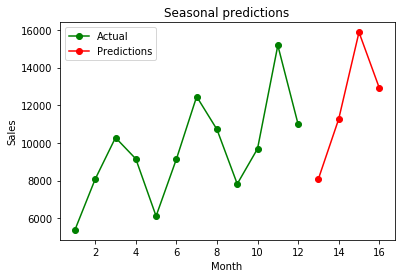

In [10]:
plt.plot(df["Month"], df["Sales"], marker='o', label="Actual", color="green");
plt.plot(range(13, 17), seasonal_predictions, marker='o', label="Predictions", color="red");

plt.title("Seasonal predictions")
plt.ylabel("Sales")
plt.xlabel("Month")
plt.legend()

### 4. Evaluation: Compare methods above

In [50]:
ground_truth = [8050, 11300, 15500, 13000]

### Mean Squared Errors

In [55]:
from sklearn.metrics import mean_squared_error

# Compare MSE seasonal predictions with ground truths
mse_seasonal = mean_squared_error(ground_truth, seasonal_predictions)

# Compare only predictions that exp smoothings made with corresponding ground truth
mse_exp_smooth1 = mean_squared_error([ground_truth[0]], [exp_smooth1[11]])
mse_exp_smooth2 = mean_squared_error([ground_truth[0]], [exp_smooth2[11]])

# Compare MA predictions with corresponding ground truths
mse_ma = mean_squared_error(ground_truth[:3], df_predict["MA"][12:])

print("MSE for seasonal prediction:               ", mse_seasonal)
print("MSE for exponential smoothing (alpha=0.2): ", mse_exp_smooth1)
print("MSE for exponential smoothing (alpha=0.8): ", mse_exp_smooth2)
print("MSE for moving average (k=3):              ", mse_ma)


MSE for seasonal prediction:                37445.26892020853
MSE for exponential smoothing (alpha=0.2):  6926854.568425617
MSE for exponential smoothing (alpha=0.8):  12588572.555425944
MSE for moving average (k=3):               12918994.453703707


### Mean Absolute Deviation

In [62]:
def mad(actual, forecast):
    total = 0
    for i in range(len(actual)):
        total += abs(actual[i] - forecast[i])
    
    return total / len(actual)


# Compare MAD seasonal predictions with ground truths
mad_seasonal = mad(ground_truth, seasonal_predictions)

# Compare only predictions that exp smoothings made with corresponding ground truth
mad_exp_smooth1 = mad([ground_truth[0]], [exp_smooth1[11]])
mad_exp_smooth2 = mad([ground_truth[0]], [exp_smooth2[11]])

# Compare MA predictions with corresponding ground truths
mad_ma = mad(ground_truth[:3], list(df_predict["MA"][12:]))

print("MAD for seasonal prediction:               ", mad_seasonal)
print("MAD for exponential smoothing (alpha=0.2): ", mad_exp_smooth1)
print("MAD for exponential smoothing (alpha=0.8): ", mad_exp_smooth2)
print("MAD for moving average (k=3):              ", mad_ma)


MAD for seasonal prediction:                132.02741095756733
MAD for exponential smoothing (alpha=0.2):  2631.891823085747
MAD for exponential smoothing (alpha=0.8):  3548.037845827739
MAD for moving average (k=3):               3398.944444444445


### MSE and MAD results are difficult to accurately compare within themselves. Especially with MSE due to the large values of the numbers and different volumes of data points to consider. This analysis could be improved through normalisation of results and narrowing assessment to compute error on the same amount of data points. <br><br>This aside, it is clear that seasonal predictions yielded the most accurate results using both error metrics.